In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import color
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [25]:
time='60min' #time step for the dataset
Office_hour_start=8 #this means 8 AM which office statrs working
Ofice_hour_end=17 #this means 5 PM which office hour ends

In [26]:
#############################Reading the original dataset and the outdoor data########################
data_original=pd.read_csv("2019Floor6.csv")
outdoo_weather = pd.read_csv("outdoor_weather.csv")
#The number of rows in the outdoo_wreather set should become equal to that of main original data
#Note: The main dataset does not have the data for the end of Nov and Dec. 
outdoo_weather.drop(range(424169,525601), axis=0, inplace=True)

In [27]:
################################Adding outdoor weather to the main dataset#################################
data=pd.concat([data_original, outdoo_weather[['Outdoor_temp(degC)', 'Radiation(kJ/(hm2))']]], axis=1)

In [28]:
###################################Omitting unnecessary data###############################################
#Here the first step is to eliminate those months when the sensors are not working.
#Then, the main important step is to keep the office hours data and set others aside. The office hours are set between 8 AM and 5 PM
#Moreover, because the data in the last day is not complete and makes it hard for general loops, so, the data for the last day is omitted as well.
#################################Step 1##############################
# Step 1 description: dropping the months that the sensors are off.
data_wos=data.drop(range(0, 93600), axis=0) #wos stands for without off sensors time

# dropping the last day for the sake of easy coding updating the indexes. 
data_wos=data_wos.drop(labels=range(423360,424169), axis=0).reset_index(drop=True)

#So far, the dataset (data_wos) covers the period between 3/7/2019  12:00:00 AM to 10/21/2019  11:59:00 PM

#################################Step 2##################################
# Step 2 description: keeping the office hours and omitting others.
#Here a loop has been written to omit the time outside the office hours in each day

Number_of_dates=len(data_wos)/(24*60) #this is the number of days in our dataset (24 means 24 hours & 60 is 60 minutes in each hour)
i = 1 #counter for dates (counter of the loop): i=1 means the 3/7/2019 (the start date in our dataset)
#The main loop for dropping unnecessary data is written below:
while i <= Number_of_dates: 
    Day_start_index=(i-1)*(24*60) #index of the start of each day (each day starts exactly from 12 AM)
    Office_start_index=int((i-1)*(24*60)+Office_hour_start*60) #index of the start of the office hour in each day
    Office_end_index=int((i-1)*(24*60)+Ofice_hour_end*60) #index of the end of office hour in each day
    Day_end_index=(i-1)*(24*60)+(24*60)-1 #index of the end of each day (each day ends exactly at 11:59 PM)
#After defining the index of the start and the end of each day as well as the office hours of each day, the data can be cleaned.
#Dropping the data outside the office hours using the above indexes calculated:
    data_wos.drop(range(Day_start_index, Office_start_index),axis=0, inplace= True)
    data_wos.drop(range(Office_end_index+1, Day_end_index+1), axis=0, inplace= True)
    i += 1

In [29]:
###########################Defining a dataset called data_office_min##############################
#Here we need to define a new dataset called data_office_min. The name of the dataset means:
#offcie: this dataset is only for office hours & min: this dataset is in minute resolution
#Morover, the index of the data_office_min needs to be updated and starts from 0 as below:
data_office_min=data_wos.reset_index(drop=True)

#All the datatypes in the dataset are ok except the first attribute ['Date']. So, it should be modified.
#Changing the data type of the 'Date' attribute to 'datetime64' as follows:
data_office_min['Date']=data_office_min['Date'].astype('datetime64')

In [30]:
##########################Imputing missing values#######################################
#At this stage, the missing values in each attributes need to be filled with appropriate alternatives
#Filling the missing values with the average of each attribute is a reasonable approach:
from sklearn.impute import SimpleImputer

#The instance object from the model has been named imputer here.
#Note1: The imputer for the 'mean' strategy applied here is for numeric values (this function does work with DateTime attribute)
#Note2: The 'Date' attribute should be omitted here for imputation (actually, it does not have any missing values as well)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_office_min_imputed=pd.DataFrame(imputer.fit_transform(data_office_min.drop(['Date'], axis=1)))
#Imputation process removed the column names. So, we put them back again in the line below:
data_office_min_imputed.columns=data_office_min.columns.drop(['Date'])
#We had to omit the Date column (the first attribute) for imputation. We bring it back to our dataset as below:
data_office_min_clean=pd.concat([data_office_min['Date'], data_office_min_imputed], axis=1)

In [31]:
#################################Adding loads for each zone together##########################################
#In general, it is a good idea to add different loads of each zone together and create a single attribute for loads in each zone.
#The summation of loads for each zone would be the target (label) attribute in the dataset.
#Adding the plug, lighting, and AC units loads together for each zone using the mapping function as below:
#Note: for using this function, a similar name should be assigned to those attributes that we want to add together.
mapping = {'z1_AC1(kW)'  : 'Zone_1_load(kW)',
           'z1_Light(kW)': 'Zone_1_load(kW)', 
           'z1_Plug(kW)' : 'Zone_1_load(kW)', #Similar name 'Zone_1_load(kW)' for zone 1
           'z2_AC1(kW)'  : 'Zone_2_load(kW)',
           'z2_Light(kW)': 'Zone_2_load(kW)',
           'z2_Plug(kW)' : 'Zone_2_load(kW)', #Similar name 'Zone_2_load(kW)' for zone 2
           'z3_Light(kW)': 'Zone_3_load(kW)',
           'z3_Plug(kW)' : 'Zone_3_load(kW)', #Similar name 'Zone_3_load(kW)' for zone 3
           'z4_AC1(kW)'  : 'Zone_4_load(kW)',
           'z4_AC2(kW)'  : 'Zone_4_load(kW)',
           'z4_AC3(kW)'  : 'Zone_4_load(kW)',
           'z4_AC4(kW)'  : 'Zone_4_load(kW)',
           'z4_Light(kW)': 'Zone_4_load(kW)',
           'z4_Plug(kW)' : 'Zone_4_load(kW)', #Similar name 'Zone_4_load(kW)' for zone 4
           'z5_AC1(kW)'  : 'Zone_5_load(kW)',
           'z5_Light(kW)': 'Zone_5_load(kW)',
           'z5_Plug(kW)' : 'Zone_5_load(kW)'} #Similar name 'Zone_5_load(kW)' for zone 5
#the below line, adds (or groups) these attributes together. 
data_office_min_clean_grouped = data_office_min_clean.set_index('Date').groupby(mapping, axis = 1).sum()
data_office_min_clean_grouped=data_office_min_clean_grouped.reset_index(level = 0)
#The data_office_min_clean_grouped dataframe includes just the above grouped attributes. Other attributes have been lost during the mapping. 
#Therefore, We need to Concatenate all attributes again here:
data_office_min_clean_grouped=pd.concat([data_office_min_clean_grouped['Date'],
                                         data_office_min_clean_grouped['Zone_1_load(kW)'],
                                         data_office_min_clean[['z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)']].round(decimals=2),
                                         data_office_min_clean_grouped['Zone_2_load(kW)'],
                                         data_office_min_clean[['z2_S1(degC)','z2_S1(RH%)','z2_S1(lux)']].round(decimals=2),
                                         data_office_min_clean_grouped['Zone_3_load(kW)'],
                                         data_office_min_clean_grouped['Zone_4_load(kW)'],
                                         data_office_min_clean[['z4_S1(degC)','z4_S1(RH%)','z4_S1(lux)']].round(decimals=2),
                                         data_office_min_clean_grouped['Zone_5_load(kW)'],
                                         data_office_min_clean[['z5_S1(degC)','z5_S1(RH%)','z5_S1(lux)']].round(decimals=2), 
                                         data_office_min_clean[['Outdoor_temp(degC)','Radiation(kJ/(hm2))']].round(decimals=2)], axis=1)   

In [32]:
#############Creating different dataset time resolutions & introducing new boolean attributes showing weekends############
data_office=data_office_min_clean_grouped
###################################dataset with X-min interval#############################   
#first, averaging over the time interval:
data_modeling=data_office.groupby([data_office['Date'].transform(pd.to_datetime).dt.floor(freq=time)]).mean().round(decimals=2).reset_index()
#second, adding the new boolean attribute for the weekend:
data_modeling=pd.concat([data_modeling[['Date']], 
                         pd.DataFrame(data=data_modeling['Date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)).rename(columns={'Date': 'Is_weekend?'}),
                         data_modeling.drop('Date', axis=1)], axis=1)

In [33]:
data_modeling.describe()

,Is_weekend?,Zone_1_load(kW),z1_S1(degC),z1_S1(RH%),z1_S1(lux),Zone_2_load(kW),z2_S1(degC),z2_S1(RH%),z2_S1(lux),Zone_3_load(kW),Zone_4_load(kW),z4_S1(degC),z4_S1(RH%),z4_S1(lux),Zone_5_load(kW),z5_S1(degC),z5_S1(RH%),z5_S1(lux),Outdoor_temp(degC),Radiation(kJ/(hm2))
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,0.288210,13.326812,24.082066,62.506380,36.710118,13.394376,23.620031,60.753454,43.662306,1.667952,13.081345,24.005707,57.813948,31.576214,5.290607,24.112642,61.851367,36.408419,31.456803,1772.663428
std,0.453028,11.298323,2.770286,6.709707,18.954980,10.853586,2.337034,6.722342,24.105419,0.640704,11.227050,2.870098,6.572289,16.090978,4.853285,2.436877,5.885001,18.071471,2.489264,764.158006
min,0.000000,0.060000,19.130000,45.680000,0.000000,0.070000,18.600000,48.820000,0.000000,0.110000,0.020000,19.020000,45.670000,0.000000,0.020000,18.630000,50.200000,0.000000,24.480000,226.970000
25%,0.000000,1.962500,21.680000,56.990000,28.955000,1.830000,21.570000,56.062500,37.035000,1.320000,2.030000,21.450000,52.562500,34.710000,1.040000,22.120000,57.190000,26.105000,29.720000,1137.777500
50%,0.000000,14.375000,23.920000,62.670000,46.420000,13.405000,23.500000,59.890000,57.230000,1.940000,13.090000,22.605000,55.670000,39.575000,4.810000,23.030000,61.230000,45.450000,31.535000,1710.205000
75%,1.000000,24.080000,26.287500,66.757500,49.270000,22.002500,25.337500,65.397500,60.320000,2.130000,23.260000,26.530000,62.930000,41.330000,8.270000,26.260000,66.237500,49.420000,33.260000,2338.135000
max,1.000000,39.630000,31.460000,84.770000,57.880000,33.370000,30.540000,85.180000,69.180000,2.630000,40.280000,31.180000,77.290000,48.500000,22.120000,31.460000,80.190000,59.050000,38.100000,3707.430000


In [34]:
######################Creating floor data (summation of loads for all zones)###############
mapping = {'Zone_1_load(kW)'  : 'Floor_6_load(kW)',
           'Zone_2_load(kW)'  : 'Floor_6_load(kW)', 
           'Zone_3_load(kW)'  : 'Floor_6_load(kW)', 
           'Zone_4_load(kW)'  : 'Floor_6_load(kW)',
           'Zone_5_load(kW)'  : 'Floor_6_load(kW)'} 
data_floor_first = data_modeling.set_index('z1_S1(degC)').groupby(mapping, axis = 1).sum()
data_floor_first = data_floor_first.reset_index(level = 0,drop=True)

In [35]:
######################Creating floor data (averaging over zones for indoor environmental measurements)###############
mapping = {'z1_S1(degC)'  : 'Floor_6_T_(degC)',
           'z2_S1(degC)'  : 'Floor_6_T_(degC)', 
           'z4_S1(degC)'  : 'Floor_6_T_(degC)', 
           'z5_S1(degC)'  : 'Floor_6_T_(degC)',
           'z1_S1(RH%)'   : 'Floor_6_RH_(%)',
           'z2_S1(RH%)'   : 'Floor_6_RH_(%)', 
           'z4_S1(RH%)'   : 'Floor_6_RH_(%)',
           'z5_S1(RH%)'   : 'Floor_6_RH_(%)',
           'z1_S1(lux)'   : 'Floor_6_ill_(lux)',
           'z2_S1(lux)'   : 'Floor_6_ill_(lux)', 
           'z4_S1(lux)'   : 'Floor_6_ill_(lux)', 
           'z5_S1(lux)'   : 'Floor_6_ill_(lux)'}
data_floor_second = data_modeling.set_index('Zone_1_load(kW)').groupby(mapping, sort=False, axis = 1).mean().round(decimals=2)
data_floor_second = data_floor_second.reset_index(level = 0,drop=True)

In [36]:
######################Creating floor data (joining previous dataframes)###############
data_floor=pd.concat([data_floor_first,
                      data_floor_second,
                      data_modeling[['Outdoor_temp(degC)', 'Radiation(kJ/(hm2))']]], axis=1)

In [37]:
######################Shuffle the dataframe and creating X and y dataframes###############
data_floor=data_floor.sample(frac=1).reset_index(drop=True)
X = data_floor.iloc[:,[1,2,3,4,5]]
y = data_floor.iloc[:, [0]]
 

In [38]:
###################################### Normalization ##############################
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
names_X = X.columns
names_y= y.columns
PredictorScalerFit=scaler.fit(X)
TargetVarScalerFit=scaler.fit(y)
d_X = scaler.fit_transform(X)
X = pd.DataFrame(d_X, columns=names_X)
d_y = scaler.fit_transform(y)
y = pd.DataFrame(d_y, columns=names_y)

In [39]:
######################### Splitting the dataset into the Training set and Test set####################

from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
#X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape), print(y_train.shape)
#print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1832, 5)
(1832, 1)
(458, 5)
(458, 1)


(None, None)

In [40]:
######################################Building the ANN##############################
#Initializing the ANN
ann = tf.keras.models.Sequential()
#Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
#Adding hidden layers
ann.add(tf.keras.layers.Dense(units=15, activation='relu'))
#ann.add(tf.keras.layers.Dense(units=45, activation='relu'))


ann.add(tf.keras.layers.Dense(units=1, activation='relu'))

In [41]:
#########################################Training the ANN#################################
#Compiling the ANN

ann.compile(optimizer = 'adam', loss = 'mean_squared_error')


#Training the ANN model on the Training set

history = ann.fit(X_train, y_train, validation_split=0.2, batch_size=50, epochs=600, shuffle=True, verbose=2)

Epoch 1/600
30/30 - 1s - loss: 0.1739 - val_loss: 0.1191 - 617ms/epoch - 21ms/step
Epoch 2/600
30/30 - 0s - loss: 0.0952 - val_loss: 0.0683 - 53ms/epoch - 2ms/step
Epoch 3/600
30/30 - 0s - loss: 0.0596 - val_loss: 0.0435 - 63ms/epoch - 2ms/step
Epoch 4/600
30/30 - 0s - loss: 0.0416 - val_loss: 0.0333 - 52ms/epoch - 2ms/step
Epoch 5/600
30/30 - 0s - loss: 0.0351 - val_loss: 0.0294 - 62ms/epoch - 2ms/step
Epoch 6/600
30/30 - 0s - loss: 0.0306 - val_loss: 0.0253 - 53ms/epoch - 2ms/step
Epoch 7/600
30/30 - 0s - loss: 0.0274 - val_loss: 0.0234 - 53ms/epoch - 2ms/step
Epoch 8/600
30/30 - 0s - loss: 0.0257 - val_loss: 0.0217 - 63ms/epoch - 2ms/step
Epoch 9/600
30/30 - 0s - loss: 0.0240 - val_loss: 0.0205 - 53ms/epoch - 2ms/step
Epoch 10/600
30/30 - 0s - loss: 0.0227 - val_loss: 0.0194 - 62ms/epoch - 2ms/step
Epoch 11/600
30/30 - 0s - loss: 0.0216 - val_loss: 0.0184 - 53ms/epoch - 2ms/step
Epoch 12/600
30/30 - 0s - loss: 0.0207 - val_loss: 0.0177 - 62ms/epoch - 2ms/step
Epoch 13/600
30/30 - 0s

Epoch 101/600
30/30 - 0s - loss: 0.0116 - val_loss: 0.0105 - 47ms/epoch - 2ms/step
Epoch 102/600
30/30 - 0s - loss: 0.0116 - val_loss: 0.0104 - 53ms/epoch - 2ms/step
Epoch 103/600
30/30 - 0s - loss: 0.0115 - val_loss: 0.0104 - 62ms/epoch - 2ms/step
Epoch 104/600
30/30 - 0s - loss: 0.0116 - val_loss: 0.0104 - 53ms/epoch - 2ms/step
Epoch 105/600
30/30 - 0s - loss: 0.0115 - val_loss: 0.0103 - 69ms/epoch - 2ms/step
Epoch 106/600
30/30 - 0s - loss: 0.0114 - val_loss: 0.0104 - 63ms/epoch - 2ms/step
Epoch 107/600
30/30 - 0s - loss: 0.0115 - val_loss: 0.0104 - 53ms/epoch - 2ms/step
Epoch 108/600
30/30 - 0s - loss: 0.0114 - val_loss: 0.0103 - 62ms/epoch - 2ms/step
Epoch 109/600
30/30 - 0s - loss: 0.0113 - val_loss: 0.0102 - 53ms/epoch - 2ms/step
Epoch 110/600
30/30 - 0s - loss: 0.0113 - val_loss: 0.0103 - 62ms/epoch - 2ms/step
Epoch 111/600
30/30 - 0s - loss: 0.0113 - val_loss: 0.0103 - 53ms/epoch - 2ms/step
Epoch 112/600
30/30 - 0s - loss: 0.0114 - val_loss: 0.0102 - 53ms/epoch - 2ms/step
Epoc

Epoch 200/600
30/30 - 0s - loss: 0.0095 - val_loss: 0.0086 - 63ms/epoch - 2ms/step
Epoch 201/600
30/30 - 0s - loss: 0.0096 - val_loss: 0.0086 - 53ms/epoch - 2ms/step
Epoch 202/600
30/30 - 0s - loss: 0.0097 - val_loss: 0.0086 - 62ms/epoch - 2ms/step
Epoch 203/600
30/30 - 0s - loss: 0.0096 - val_loss: 0.0086 - 53ms/epoch - 2ms/step
Epoch 204/600
30/30 - 0s - loss: 0.0096 - val_loss: 0.0088 - 100ms/epoch - 3ms/step
Epoch 205/600
30/30 - 0s - loss: 0.0097 - val_loss: 0.0087 - 62ms/epoch - 2ms/step
Epoch 206/600
30/30 - 0s - loss: 0.0095 - val_loss: 0.0088 - 48ms/epoch - 2ms/step
Epoch 207/600
30/30 - 0s - loss: 0.0095 - val_loss: 0.0087 - 56ms/epoch - 2ms/step
Epoch 208/600
30/30 - 0s - loss: 0.0095 - val_loss: 0.0086 - 63ms/epoch - 2ms/step
Epoch 209/600
30/30 - 0s - loss: 0.0094 - val_loss: 0.0088 - 53ms/epoch - 2ms/step
Epoch 210/600
30/30 - 0s - loss: 0.0096 - val_loss: 0.0087 - 47ms/epoch - 2ms/step
Epoch 211/600
30/30 - 0s - loss: 0.0095 - val_loss: 0.0088 - 53ms/epoch - 2ms/step
Epo

Epoch 299/600
30/30 - 0s - loss: 0.0088 - val_loss: 0.0085 - 53ms/epoch - 2ms/step
Epoch 300/600
30/30 - 0s - loss: 0.0089 - val_loss: 0.0082 - 69ms/epoch - 2ms/step
Epoch 301/600
30/30 - 0s - loss: 0.0088 - val_loss: 0.0083 - 47ms/epoch - 2ms/step
Epoch 302/600
30/30 - 0s - loss: 0.0091 - val_loss: 0.0094 - 69ms/epoch - 2ms/step
Epoch 303/600
30/30 - 0s - loss: 0.0092 - val_loss: 0.0083 - 47ms/epoch - 2ms/step
Epoch 304/600
30/30 - 0s - loss: 0.0088 - val_loss: 0.0085 - 53ms/epoch - 2ms/step
Epoch 305/600
30/30 - 0s - loss: 0.0089 - val_loss: 0.0083 - 62ms/epoch - 2ms/step
Epoch 306/600
30/30 - 0s - loss: 0.0089 - val_loss: 0.0083 - 53ms/epoch - 2ms/step
Epoch 307/600
30/30 - 0s - loss: 0.0089 - val_loss: 0.0082 - 47ms/epoch - 2ms/step
Epoch 308/600
30/30 - 0s - loss: 0.0087 - val_loss: 0.0082 - 53ms/epoch - 2ms/step
Epoch 309/600
30/30 - 0s - loss: 0.0088 - val_loss: 0.0083 - 53ms/epoch - 2ms/step
Epoch 310/600
30/30 - 0s - loss: 0.0089 - val_loss: 0.0082 - 47ms/epoch - 2ms/step
Epoc

Epoch 398/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0083 - 78ms/epoch - 3ms/step
Epoch 399/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0081 - 53ms/epoch - 2ms/step
Epoch 400/600
30/30 - 0s - loss: 0.0083 - val_loss: 0.0082 - 53ms/epoch - 2ms/step
Epoch 401/600
30/30 - 0s - loss: 0.0085 - val_loss: 0.0086 - 63ms/epoch - 2ms/step
Epoch 402/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0081 - 53ms/epoch - 2ms/step
Epoch 403/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0083 - 62ms/epoch - 2ms/step
Epoch 404/600
30/30 - 0s - loss: 0.0085 - val_loss: 0.0082 - 53ms/epoch - 2ms/step
Epoch 405/600
30/30 - 0s - loss: 0.0085 - val_loss: 0.0087 - 62ms/epoch - 2ms/step
Epoch 406/600
30/30 - 0s - loss: 0.0085 - val_loss: 0.0083 - 47ms/epoch - 2ms/step
Epoch 407/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0081 - 53ms/epoch - 2ms/step
Epoch 408/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0081 - 47ms/epoch - 2ms/step
Epoch 409/600
30/30 - 0s - loss: 0.0084 - val_loss: 0.0082 - 53ms/epoch - 2ms/step
Epoc

Epoch 497/600
30/30 - 0s - loss: 0.0081 - val_loss: 0.0080 - 62ms/epoch - 2ms/step
Epoch 498/600
30/30 - 0s - loss: 0.0082 - val_loss: 0.0084 - 49ms/epoch - 2ms/step
Epoch 499/600
30/30 - 0s - loss: 0.0083 - val_loss: 0.0082 - 73ms/epoch - 2ms/step
Epoch 500/600
30/30 - 0s - loss: 0.0082 - val_loss: 0.0080 - 47ms/epoch - 2ms/step
Epoch 501/600
30/30 - 0s - loss: 0.0085 - val_loss: 0.0080 - 53ms/epoch - 2ms/step
Epoch 502/600
30/30 - 0s - loss: 0.0081 - val_loss: 0.0080 - 63ms/epoch - 2ms/step
Epoch 503/600
30/30 - 0s - loss: 0.0082 - val_loss: 0.0080 - 53ms/epoch - 2ms/step
Epoch 504/600
30/30 - 0s - loss: 0.0082 - val_loss: 0.0080 - 78ms/epoch - 3ms/step
Epoch 505/600
30/30 - 0s - loss: 0.0082 - val_loss: 0.0081 - 53ms/epoch - 2ms/step
Epoch 506/600
30/30 - 0s - loss: 0.0081 - val_loss: 0.0080 - 53ms/epoch - 2ms/step
Epoch 507/600
30/30 - 0s - loss: 0.0081 - val_loss: 0.0081 - 63ms/epoch - 2ms/step
Epoch 508/600
30/30 - 0s - loss: 0.0082 - val_loss: 0.0081 - 69ms/epoch - 2ms/step
Epoc

Epoch 596/600
30/30 - 0s - loss: 0.0079 - val_loss: 0.0079 - 47ms/epoch - 2ms/step
Epoch 597/600
30/30 - 0s - loss: 0.0079 - val_loss: 0.0080 - 53ms/epoch - 2ms/step
Epoch 598/600
30/30 - 0s - loss: 0.0078 - val_loss: 0.0079 - 63ms/epoch - 2ms/step
Epoch 599/600
30/30 - 0s - loss: 0.0079 - val_loss: 0.0078 - 53ms/epoch - 2ms/step
Epoch 600/600
30/30 - 0s - loss: 0.0078 - val_loss: 0.0080 - 53ms/epoch - 2ms/step


In [42]:
#####################Predicting the results of the Test set and errors##############################
y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
sc = ann.evaluate(X_test,y_test,verbose = 0)

#calculate R2
r2 = r2_score(y_test, y_pred)
print('Coefficient of Determination(R2):', r2)
#calculate RMSE
RMSE = sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error(RMSE):', sqrt(mean_squared_error(y_test, y_pred)))

y_pred_orig=TargetVarScalerFit.inverse_transform(y_pred)
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# #calculate MAPE
MAPE=(abs(y_test_orig-y_pred_orig)/y_test_orig).mean() *100
print('Mean Absolute Percentage Error(MAPE):', MAPE)

#calculate MAE
print('Mean Absolute Error(MAE):', mae(y_test, y_pred))

Coefficient of Determination(R2): 0.9256322562672318
Root Mean Squared Error(RMSE): 0.08440907035819782
Mean Absolute Percentage Error(MAPE): 27.777190021172654
Mean Absolute Error(MAE): 0.05595038350557059


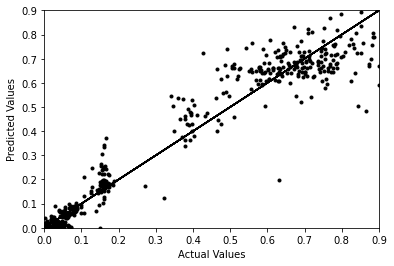

In [43]:
plt.scatter(y_test,y_pred, marker = ".", color="black")
plot1=plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim([0,0.9])
plt.ylim([0,0.9])
plt.plot(y_test,y_test, color="black")
plt.show()

Text(0, 0.5, 'Loss')

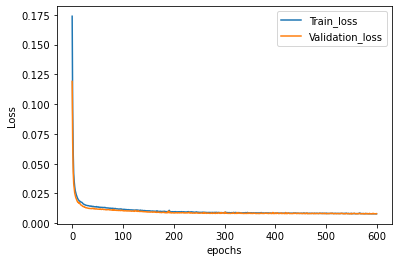

In [44]:
pd.DataFrame(history.history).plot()
plt.legend(['Train_loss', 'Validation_loss'], loc='upper right')
plot2=plt.xlabel("epochs")
plt.ylabel("Loss")

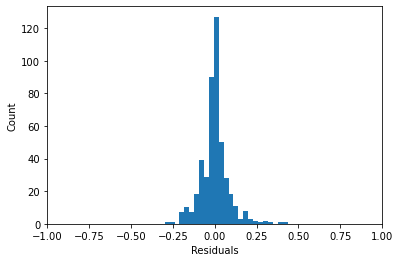

In [45]:
error = y_test - y_pred
plt.hist(error, bins=25)
plt.xlim([-1,1])
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()